## BERT Pretrained Model 제작

머리말
<br/>개발 환경
<br/>데이터 정보
<br/>SentencePiece

Masked Language Model Train Data
<br/>MASK
<br/>NSP pair
<br/>File I/O


모델 구성
<br/>Utility Function
<br/>Config
<br/>Token Embedding
<br/>Segment Embedding
<br/>Position Embedding
<br/>Transformer Encoder
<br/>BERT
<br/>Loss Function
<br/>Learning Rate Schedule

Hyperparameter
<br/>First Model
<br/>Second Model
<br/>Third Model
<br/>Model Selection
<br/>최종 모델
<br/>Load Model
<br/>결론
<br/>참고문헌

#머리말

전체 파라미터 사이즈가 1M 정도가 되는 Mini BERT 모델을 만들어 수백 MB 수준의 코퍼스 기반으로 Pretrain을 진행한다.
<br/>코퍼스 데이터를 가공해서 학습 Task에 적합한 형태의 데이터셋을 만든다.

#개발 환경

In [ ]:
!pip install sentencepiece

In [1]:
import os
import json
import h5py
import shutil
import zipfile
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import math
import copy
import collections
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import HTML
from IPython.display import Image
from IPython.display import display

In [3]:
import numpy as np
import pandas as pd

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K

In [5]:
import re
import sentencepiece as spm

In [6]:
import random
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['numpy=', 'pandas=', 'tensorflow=', 'keras=', 'tqdm=',
                'zip', 'future', 'matplotlib=','regex=', 'sentencepiece']
library_version = []
count = 0

import sys
print(sys.version)
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())
print()

with open('/content/drive/MyDrive/lms/library_version.txt', 'r') as f:
    lines = f.read().splitlines() 

for i in range(len(lines)):
  for line in lines[i:i+1]:
    for library in library_name:
      if library in line:
        library_version.append(line)
        count += 1
        print(line, end = '    ')
        if count % 3 == 0:
          print()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
2.8.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0

future==0.16.0    keras==2.8.0    matplotlib==3.2.2    
numpy==1.21.6    pandas==1.3.5    regex==2022.6.2    
sentencepiece==0.1.96    sklearn-pandas==1.8.0    tensorflow==2.8.2+zzzcolab20220719082949    
tqdm==4.64.0    zipp==3.8.1    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

#데이터 정보

[kowiki](https://paul-hyun.github.io/nlp-tutorial-02-02-tokenizer/)

[나무위키](https://namu.wiki/w/%EB%82%98%EB%AC%B4%EC%9C%84%ED%82%A4:%EB%8C%80%EB%AC%B8) 코퍼스이다.

In [ ]:
corpus_file = "/content/drive/MyDrive/lms/sp_tokenizer/kowikitext/kowiki.txt"

with open(corpus_file, "r") as f:
    kowiki = f.read().splitlines()

print("Data Size:", len(kowiki))
print()
print("Example")
for sen in kowiki[80:81]:
    print("", sen)

Data Size: 3724342

Example
 아마도 통제 된 방식으로 사용 된 최초의 화학 반응은 불이였다. 그러나 천년 동안 불는 단순히 열과 빛을 생성하면서 한 물질을 다른 물질 (타는 나무 또는 끓는 물)로 변형시킬 수있는 신비한 힘으로만 알려졌다. 불는 초기 사회의 여러 측면에 영향을 미쳤다. 이들은 요리 및 서식지 조명과 같은 일상 생활의 가장 단순한면에서 도기, 벽돌 및 금속을 녹여 도구를 만드는 것과 같은 고급 기술에 이르기까지 다양했다.


<br/>

#SentencePiece

BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 한다.
<br/>시간이 부족하다면 클라우드에 저장된 SentencePiece 모델을 사용한다.

In [9]:
corpus = "/content/drive/MyDrive/lms/bert_pretrain/data/kowiki.txt"
prefix = "ko_8000"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + 
    " --pad_id=0 --pad_piece=[PAD]" + 
    " --unk_id=1 --unk_piece=[UNK]" + 
    " --bos_id=2 --bos_piece=[BOS]" + 
    " --eos_id=3 --eos_piece=[EOS]" + 
    " --user_defined_symbols=[SEP],[CLS],[MASK]") 

!ls -l ko_8000*

-rw-r--r-- 1 root root 350324 Aug  8 15:43 ko_8000.model
-rw-r--r-- 1 root root  95430 Aug  8 15:43 ko_8000.vocab


corpus는 학습용 말뭉치이다.
<br/>prefix는 저장할 vocab 이름이다.
<br/>vocab_size에 7를 더한다. 7은 특수문자 개수이다.
<br/>model_type은 bpe이다.
<br/>max_sentence_length를 default 999999로 설정한다.
<br/>token은 [PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK]으로 구성된다.
<br/>pad_id는 0, unk_id는 1, bos_id는 2, eos_id는 3으로 설정한다.
<br/>bos는 begin of sequence, eos는 end of sequence를 의미한다.
<br/>user_defined_symbols는 모델 구성을 위한 [SEP] : 4, [CLS] : 5, [MASK] : 6으로 설정한다.

[CLS] : sentence의 시작을 알리는 토큰
<br/>[SEP] : sentence의 종결을 알리는 토큰. sentence를 구분하는 데에 사용한다.
<br/>[MASK] : 마스크 토큰
<br/>[PAD] : 배치 데이터의 길이를 맞추는 토큰

In [ ]:
vocab = spm.SentencePieceProcessor()
vocab.load("ko_8000.model")

In [ ]:
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

for i in range(len(vocab_list) // 100):
  if i % 10 == 0 and i <= (len(vocab_list) - 10):
    print("    ".join(vocab_list[i:i+10]))

▁1    ▁이    으로    에서    ▁있    ▁2    ▁그    ▁대    ▁사    이다
었다    ▁지    ▁수    ▁시    ▁19    ▁가    ▁기    ▁전    ▁20    ▁아
▁하    ▁있다    ▁다    ▁제    했다    ▁일    하였    ▁한    ▁정    ▁중
▁주    하는    ▁것    ▁자    ▁공    되었다    ▁경    ▁인    ▁위    ▁유
하고    ▁보    ▁3    ▁등    ▁부    하였다    ▁조    하여    ▁선    ▁동
▁나    으며    ▁모    ▁미    ▁연    ▁오    ▁마    에는    ▁영    ▁의
▁발    ▁소    한다    ▁고    ▁구    ▁개    ▁세    ▁도    ▁201    ▁상
▁비    ▁스    ▁서    ▁국    ▁200    ▁후    ▁여    ▁때    ▁4    ▁성


<br/>

#Masked Language Model Train Data

Masked Language Model(MLM)은 GPT의 Next Token Prediction 태스크처럼 다음이 이어질 단어를 예측하는 것이 아니라
<br/>마스킹 이후 빈칸에 알맞은 단어를 예측하며 문제를 푸는 형식으로 구성된다.

##MASK

In [37]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만든다.
<br/>그 중 80%는 [ MASK ] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용한다.
<br/>Masked LM 태스크를 구성할 때는 띄어쓰기 단위로 마스킹한다.
<br/>Masked LM의 라벨 데이터를 생성한다.

In [ ]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 
string_a = "한 번 더 나에게 질풍 같은 용기를 거친 파도에도 굴하지 않게"
string_b = "드넓은 대지에 다시 새길 희망을 안고 달려갈 거야 너에게"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]

In [ ]:
# tokens가 mask되므로 재실행을 위해서 넣어줌 (시험용)
tokens = copy.deepcopy(tokens_org)
mask_cnt = int((len(tokens_org) - 3) * 0.15)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(" ".join(tokens_org), "\n")
print("tokens")
print(" ".join(tokens), "\n")
print("mask_idx")
print(", ".join(map(str, mask_idx)), "\n")
print("mask_label")
print(" ".join(mask_label), "\n")

tokens_org
[CLS] ▁한 ▁번 ▁더 ▁나 에게 ▁질 풍 ▁같은 ▁용 기를 ▁거 친 ▁파 도 에도 ▁굴 하지 ▁않 게 [SEP] ▁드 넓 은 ▁대 지에 ▁다시 ▁새 길 ▁희 망 을 ▁안 고 ▁달 려 갈 ▁거 야 ▁너 에게 [SEP] 

tokens
[CLS] ▁한 [MASK] ▁더 ▁나 에게 [MASK] [MASK] ▁같은 ▁용 기를 ▁거 친 ▁파 도 에도 ▁굴 하지 ▁않 게 [SEP] ▁드 넓 은 ▁대 지에 ▁다시 ▁새 길 ▁희 망 을 ▁안 고 ▁달 려 갈 ▁거 야 [MASK] [MASK] [SEP] 

mask_idx
2, 6, 7, 39, 40 

mask_label
▁번 ▁질 풍 ▁너 에게 



예를 들어 유정석 <질풍가도 ('쾌걸 근육맨 2세' 1기 여는노래)> 가사의 Mask Token을 생성한다.

<br/>

## NSP pair

BERT의 Pretrain Task로 Next Sentence Prediction이 있다.
<br/>문장 2개를 붙여 놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞춘다.
<br/>이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.
<br/>두 문장 사이에 Segment를 처리한다.
<br/>첫 번째 문장의 Segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자 [ SEP ] 등을 넣는다.
<br/>MLM과 NSP는 동시에 학습된다는 것을 고려하며 학습 데이터를 구성한다.

In [38]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [39]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

특수 token은 [ CLS ]와 [ SEP ]이고 sequence의 최대 길이는 n_test_seq - 3으로 정한다.
<br/>짝지은 두 문장을 그대로 두면 NSP Task의 true label case가 되고, 둘의 순서를 뒤바꾸면 false label case가 된다.
<br/>두 문장의 최대 길이를 유지하도록 trim을 적용한 후 50%의 확률로 true/false case를 생성한다.
<br/>token A의 길이가 max_seq보다 길면 앞에서부터 토큰을 제거하고 token B의 길이가 길면 뒤에서부터 토큰을 제거한다.

두 문장 사이에 segment 처리를 한다.
<br/>첫 번째 문장의 segment는 모두 0으로 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [ SEP ] 등을 넣는다.
<br/>create_pretrain_mask까지 함께 호출되어 Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋을 제작한다.
<br/>BERT의 pretrain은 MLM, NSP Task가 동시에 수행된다.

In [ ]:
string = """여기까지가 끝인가보오 이제 나는 돌아서겠소
억지 노력으로 인연을 거슬러 괴롭히지는 않겠소
하고 싶은 말 하려 했던 말 이대로 다 남겨 두고서
혹시나 기대도 포기하려하오 그대 부디 잘 지내시오"""

doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
n_test_seq = 64

In [ ]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

for instance in instances:
    for key, value in instance.items():
      print(key)
      if type(value) == list:
        if type(value[0]) == str:
          print(" ".join(value))
        elif type(value[0]) == int:
          print(", ".join(map(str, value)))
      else:
        print(value)
      print()

tokens
[CLS] 가 ▁끝 인 가 보 오 ▁이 제 [MASK] [MASK] ▁돌아 서 겠 소 ▁억 지 [MASK] [MASK] ▁인 연 을 ▁거 슬 러 ▁괴 롭 히 지는 ▁않 겠 소 [SEP] ▁하고 ▁싶 은 ▁말 ▁하 려 ▁ 했던 ▁말 ▁이 대로 [MASK] ▁남 겨 ▁두고 서 ▁혹 시 나 ▁기 대 도 ▁포 기 하려 하 오 [MASK] [MASK] ▁부 [SEP]

segment
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

is_next
1

mask_idx
9, 10, 17, 18, 37, 38, 44, 60, 61

mask_label
▁나 는 ▁노 력으로 ▁하 려 ▁다 ▁그 대



예를 들어 김광진 <편지> 가사의 MLM, NSP Task를 진행한다.

<br/>

In [ ]:
# line count 확인
corpus_file = '/content/drive/MyDrive/lms/bert_pretrain/data/kowiki.txt'
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

n_test_seq = 64

# 위키가 주제별로 잘 나눠지는지 여부 확인
# 100개의 주제 중에서 무작위로 5개 추출
count = 100
num_list = []
for i in range(100):
  num_list.append(i)
sample_num = random.sample(num_list, 5)

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)  
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    if count in sample_num:
                      print("\n")
                      print("topic:", " ".join(doc[0]))
                      print(" ".join(doc[1]))
                      print("\n")

                      instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                      # save
                      print("doc:", len(doc), " instances:", len(instances))
                      for item in instances[0].items():
                          print(item[0], end= '  ')
                          if type(item[1]) == list:
                              if type(item[1][0]) == str:
                                  print(" ".join(item[1]))
                              elif type(item[1][0]) == int:
                                  print(", ".join(map(str, item[1])))
                          else:
                              print(item[1])
                      print("\n")

                else:
                    break
                doc = []

        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line) 
            if 0 < len(pieces):
                doc.append(pieces)

  0%|          | 0/3724301 [00:00<?, ?it/s]



topic: ▁문학
▁문학 ( 文 學 ) 은 ▁언 어를 ▁예술 적 ▁표현 의 ▁제 재 로 ▁삼 아 ▁새로운 ▁의미 를 ▁창 출 하여 , ▁인간 과 ▁사회 를 ▁진 실 되 게 ▁묘사 하는 ▁예술 의 ▁하 위 분 야 이다 . ▁간 단 하게 ▁설명 하면 , ▁언 어를 ▁통해 ▁인간의 ▁삶 을 ▁미 적 ( 美 的 ) 으로 ▁형 상 화 한 ▁것이라고 ▁볼 ▁수 ▁있다 . ▁문학 은 ▁원래 ▁문 예 ( 文 藝 ) 라고 ▁부 르는 ▁것이 ▁ 옳 으며 , ▁문 학을 ▁학 문 의 ▁대상 으로서 ▁탐 구 하는 ▁학 문 의 ▁명칭 ▁역시 ▁문 예 학 이다 . ▁문 예 학 은 ▁음악 사 학 , ▁미술 사 학 ▁등과 ▁함께 ▁예술 학의 ▁핵 심 분 야 로서 ▁인 문 학의 ▁하 위 범 주에 ▁포함 된다 .


doc: 10  instances: 4
tokens  [CLS] 藝 ) 라고 ▁부 르는 ▁것이 [MASK] [MASK] [MASK] [MASK] ▁문 학을 ▁학 문 의 ▁대상 으로서 [MASK] [MASK] [MASK] ▁학 문 의 ▁명칭 ▁역시 ▁문 예 학 이다 . ▁문 예 학 은 ▁음악 사 학 , ▁미술 사 학 [MASK] ▁함께 ▁예술 학의 ▁핵 심 분 야 로서 ▁인 문 학의 ▁하 위 범 주에 ▁포함 된다 . [SEP] [MASK] [SEP]
segment  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1
is_next  0
mask_idx  7, 8, 9, 10, 18, 19, 20, 42, 62
mask_label  ▁ 옳 으며 , ▁탐 구 하는 ▁등과 ▁문학




topic: ▁주 기 율 표
▁주 기 율 표 ( 週 期 律 表 , ▁, ▁) ▁또는 ▁주 기 표 ( 週 期 表 )

위키 문서는 하나의 document가 주제 키워드에 대해 상세 내용이 설명으로 따라붙어 있는 형태로 구성된다.
<br/>데이터가 document 주제별로 분리가 되는지 확인한다.
<br/>create_pretrain_instances를 코퍼스에 적용할 수 있는지 확인한다.

<br/>

##File I/O

In [40]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [41]:
corpus_file = '/content/drive/MyDrive/lms/bert_pretrain/data/kowiki.txt'
pretrain_json_path = '/content/drive/MyDrive/lms/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3724301 [00:00<?, ?it/s]

BERT pretrain 데이터셋을 생성해 json 포맷으로 저장한다.

In [42]:
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
        
print(total)

863207


전체 line 수가 863,207이다.

In [43]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [44]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


데이터셋의 크기가 크므로 np.memmap을 사용해 메모리 사용량을 최소화한다.
<br/>128,000건만 메모리에 할당한다.

In [45]:
print("Input Type")
print(type(pre_train_inputs[0]))
print(type(pre_train_inputs[0][0]))
print()
print("Label Type")
print(type(pre_train_labels[0]))
print(type(pre_train_labels[0][0]))

Input Type
<class 'numpy.memmap'>
<class 'numpy.memmap'>

Label Type
<class 'numpy.memmap'>
<class 'numpy.int32'>


In [139]:
print("Input\n")
print("pre_train_inputs[0][0]\n", pre_train_inputs[0][0], "\n")
print("pre_train_inputs[0][-1]\n", pre_train_inputs[0][-1], "\n")
print("pre_train_inputs[1][0]\n", pre_train_inputs[1][0], "\n")
print("pre_train_inputs[1][-1]\n", pre_train_inputs[1][-1], "\n")

Input

pre_train_inputs[0][0]
 [   5   18 3680  210 3705    4 3342 1034    6    6    6    6    6    6
   37 3456  446  793 3656 3616    6    6    7 3620    6    6    6 1143
 3718  785  257   49 3623  803    6 1684 3671 3671 3616  198 2975 3616
 3607   16 3590 3378 7763  210 3705 3593 1751 3621 3637  607 3705  210
 3750 3827  430 3730 3619 3618 1372   10 1572 3590 1751 3621   41 3635
  815 3615 1103   52 3590   13   82   87 1514 2226   24 3768 3861 3658
 3622 3801 3861 4188 3627 3768 3592  240 3714 1220   32   52 3590  478
 3643 3616  257 2765   14 1508  172 3866  425  165 1696 4286 3861 3693
 3676    6   22 4997  395 1939 3598    6    6    6  305  580  933  103
 4304    4] 

pre_train_inputs[0][-1]
 [   5 3592    6    6    6    6    6 1430 1530 3642  832 1826    6    6
  143  670  506 3636  221 1574  586 3044  160 3723  975  328 3802  995
 3655  518 4164 3598   14 3936    6    6  522    6    6  296  976 3665
 3795 3592 1365 2246 3615    6    6    6  160 3723 1068 2701 2647    6
    6  

In [140]:
print("Label\n")
print("pre_train_labels[0][0]\n", pre_train_labels[0][0], "\n")
print("pre_train_labels[0][-1]\n", pre_train_labels[0][-1], "\n")
print("pre_train_labels[1][0]\n", pre_train_labels[1][0], "\n")
print("pre_train_labels[1][-1]\n", pre_train_labels[1][-1], "\n")

Label

pre_train_labels[0][0]
 1 

pre_train_labels[0][-1]
 1 

pre_train_labels[1][0]
 [   0    0    0    0    0    0    0    0  103 3601 3680 3709  210 3705
    0    0    0    0    0    0  129 3652    0    0  198  237 3593    0
    0    0    0    0    0    0  659    0    0    0    0    0    0    0
    0    0    0   18 3680    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  586    0    0    0    0    0  810   17 3590    0    0    0    0
    0    0] 

pre_train_labels[1][-1]
 [   0    0   19 3611 3776 1749 2326    0    0    0    0    0   29 2755
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 3097  166    0 2055 3595    0    0    0
    0    0    0    0 

데이터의 처음과 마지막을 확인한다.

#모델 구성

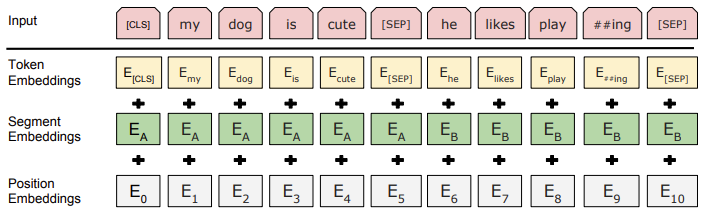

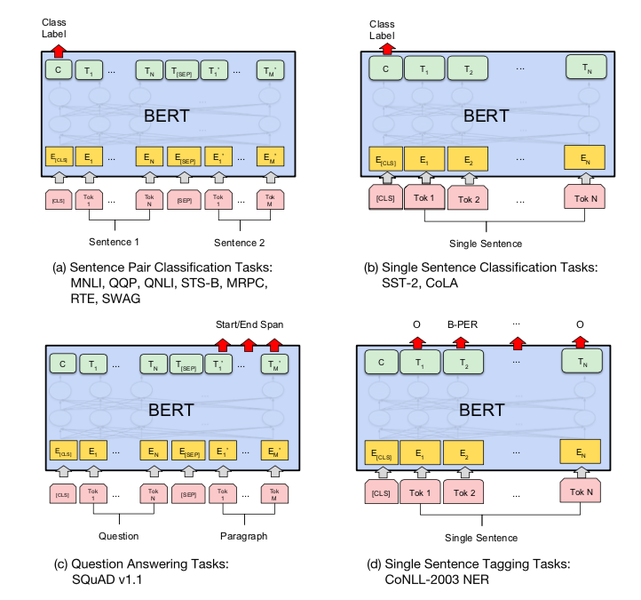

In [ ]:
file_path = '/content/drive/MyDrive/lms/bert_pretrain/'
x = Image(filename= file_path + 'bert_embedding_layer.png') 
y = Image(filename= file_path + 'bert_task.png') 
display(x)
print("\n" * 4)
display(y)

<br/>

##Utility Function

In [16]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [17]:
def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [18]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [20]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

In [19]:
def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

##Config

In [21]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

json을 config 형태로 사용한다.

##Token Embedding

학습한 Wordpiece Model을 이용하여 Token을 임베딩한다.

In [22]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

##Position Embedding

Sentence 안에서의 순서는 아직 모르는 상태이다. 
<br/>Position Embedding은 문장 안의 위치(순서)를 알려준다.
<br/>[SEP] 토큰으로 구분된 두 sentence에서 앞부분은 A, 뒷부분은 B로 나누어 임베딩한다.

In [23]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

##Segment Embedding

BERT는 Sentence를 문장의 의미보다는 텍스트 덩어리의 의미로 받아들인다.
<br/>Segment Embedding은 모델 입장에서 주르륵 이어진 텍스트들의 덩어리를 나누어주는 역할을 한다.  

In [24]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

##Transformer Encoder

In [26]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

##BERT

In [28]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [29]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [30]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [46]:
config = Config({"d_model": 256,
                 "n_head": 4,
                 "d_head": 64,
                 "dropout": 0.1,
                 "d_ff": 1024,
                 "layernorm_epsilon": 0.001,
                 "n_layer": 3,
                 "n_seq": 256,
                 "n_vocab": 0,
                 "i_pad": 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007}

<br/>

In [47]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

In [48]:
test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

In [ ]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 256),        4485632     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                              

<br/><br/>

In [ ]:
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 3s 12ms/step - loss: 9.7747 - nsp_loss: 0.7198 - mlm_loss: 9.0549 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 10ms/step - loss: 8.5973 - nsp_loss: 0.6165 - mlm_loss: 7.9808 - nsp_acc: 0.8000 - mlm_acc: 0.0000e+00


Pretrained BERT 모델을 생성하여 모델 작동을 확인한다.

<br/>

##Loss Function

In [32]:
def lm_loss(y_true, y_pred):
    """
    loss 계산
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [33]:
def lm_acc(y_true, y_pred):
    """
    accuracy 계산
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

##Learning Rate Schedule 

In [34]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

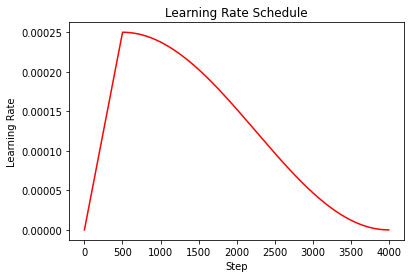

In [ ]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.title("Learning Rate Schedule")
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.show()

WarmUp 이후 Consine 형태로 감소하는 스케줄을 적용한다.
<br/>Learning Rate를 단순히 감소시키기 보다는 진동하면서 최적점을 찾는다.

<br/>

#Hyperparameter

In [ ]:
reorderlist = ['Model Dimension', 'Feedforwad Hidden Layer', 'Feedforwad Hidden Layer Dimension', 'Feedforward Network Dimension',
               'Layer Normalization Epsilon', 'Number of Layer', 'Sequence Size', 'Number of Vocab', "Pad ID", 'Tokenizer', 'Vocab Size', 
               'Dropout Rate', 'Learning Rate', 'Optimizer', 'Activation Function', 'Loss Function', 'Epoch', 'Batch Size', 'Total Parameter']

hyperparameter = pd.DataFrame({'First Model':{'Model Dimension':256, 'Feedforwad Hidden Layer':4,
                                                    'Feedforwad Hidden Layer Dimension':64, 'Feedforward Network Dimension':1024,
                                                    'Layer Normalization Epsilon':0.001, 'Number of Layer':3, 'Sequence Size':256,
                                                    'Number of Vocab':8007, "Pad ID":0,  'Tokenizer':'SentencePiece', 'Vocab Size':8000,
                                                    'Dropout Rate':0.1, 'Learning Rate':'Scheduler', 'Optimizer':'Adam',
                                                    'Activation Function':'Gelu', 'Loss Function':'Sparse Categorical Crossentropy',
                                                    'Epoch':10, 'Batch Size':128, 'Total Parameter':4551936}})

hyperparameter = hyperparameter.iloc[pd.Categorical(hyperparameter.index,reorderlist).argsort()]

hyperparameter.loc[:,'Second Model'] = [128, 4, 64, 512, 0.001, 3, 256, 8007, 0, 'SentencePiece', 8000, 0.1, 'Scheduler', 'Adam',
                                              'Gelu', 'Sparse Categorical Crossentropy', 10, 128, 1867520]
hyperparameter.loc[:,'Third Model'] = [64, 4, 64, 256, 0.001, 3, 256, 8007,0, 'SentencePiece', 8000, 0.1, 'Scheduler', 'Adam',
                                              'Gelu', 'Sparse Categorical Crossentropy', 10, 128, 832512]


pd.set_option('display.max_columns', None)
hyperparameter

,First Model,Second Model,Third Model
Model Dimension,256,128,64
Feedforwad Hidden Layer,4,4,4
Feedforwad Hidden Layer Dimension,64,64,64
Feedforward Network Dimension,1024,512,256
Layer Normalization Epsilon,0.001,0.001,0.001
Number of Layer,3,3,3
Sequence Size,256,256,256
Number of Vocab,8007,8007,8007
Pad ID,0,0,0
Tokenizer,SentencePiece,SentencePiece,SentencePiece


<br/>

#First Model

In [ ]:
config_1 = Config({"d_model": 256,
                 "n_head": 4,
                 "d_head": 64,
                 "dropout": 0.1,
                 "d_ff": 1024,
                 "layernorm_epsilon": 0.001,
                 "n_layer": 3,
                 "n_seq": 256,
                 "n_vocab": 0,
                 "i_pad": 0})

config_1.n_vocab = len(vocab)
config_1.i_pad = vocab.pad_id()
config_1

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007}

<br/>

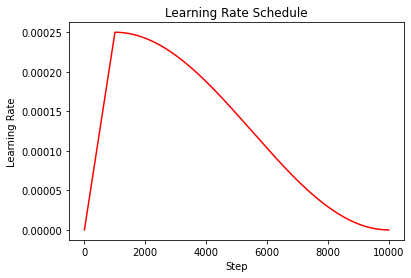






Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 256),        4485632     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                       

In [ ]:
epochs = 10
batch_size = 128

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
lrs = []
for step_num in range(train_steps):
    lrs.append(learning_rate(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.title("Learning Rate Schedule")
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.show()
print("\n" * 4)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model = build_model_pre_train(config_1)
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
                        optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})
pre_train_model.summary()

<br/><br/>

In [ ]:
# save weights callback
model_dir = '/content/drive/MyDrive/lms/bert_pretrain/model'
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/first_bert_pre_train.hdf5", monitor="mlm_lm_acc",
                                                  verbose=0, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
1000/1000 [==============================] - 168s 163ms/step - loss: 19.9153 - nsp_loss: 0.6521 - mlm_loss: 19.2632 - nsp_acc: 0.5926 - mlm_lm_acc: 0.1085
Epoch 2/10
1000/1000 [==============================] - 164s 164ms/step - loss: 17.7894 - nsp_loss: 0.6241 - mlm_loss: 17.1653 - nsp_acc: 0.6193 - mlm_lm_acc: 0.1281
Epoch 3/10
1000/1000 [==============================] - 164s 164ms/step - loss: 17.0763 - nsp_loss: 0.6117 - mlm_loss: 16.4646 - nsp_acc: 0.6349 - mlm_lm_acc: 0.1345
Epoch 4/10
1000/1000 [==============================] - 164s 164ms/step - loss: 16.3482 - nsp_loss: 0.6075 - mlm_loss: 15.7407 - nsp_acc: 0.6411 - mlm_lm_acc: 0.1448
Epoch 5/10
1000/1000 [==============================] - 164s 164ms/step - loss: 14.9680 - nsp_loss: 0.6065 - mlm_loss: 14.3614 - nsp_acc: 0.6460 - mlm_lm_acc: 0.1677
Epoch 6/10
1000/1000 [==============================] - 164s 164ms/step - loss: 14.1599 - nsp_loss: 0.6019 - mlm_loss: 13.5580 - nsp_acc: 0.6551 - mlm_lm_acc: 0.1874
Epoc

<br/><br/>

,Epoch,Loss,NSP Loss,MLM Loss,NSP Accuracy,MLM Accuracy
0,1,19.9153,0.6521,19.2632,0.5926,0.1085
1,2,17.7894,0.6241,17.1653,0.6193,0.1281
2,3,17.0763,0.6117,16.4646,0.6349,0.1345
3,4,16.3482,0.6075,15.7407,0.6411,0.1448
4,5,14.9680,0.6065,14.3614,0.6460,0.1677
5,6,14.1599,0.6019,13.5580,0.6551,0.1874
6,7,13.7392,0.5957,13.1435,0.6653,0.1984
7,8,13.5014,0.5898,12.9115,0.6784,0.2048
8,9,13.3750,0.5852,12.7898,0.6845,0.2081
9,10,13.3245,0.5820,12.7425,0.6897,0.2095


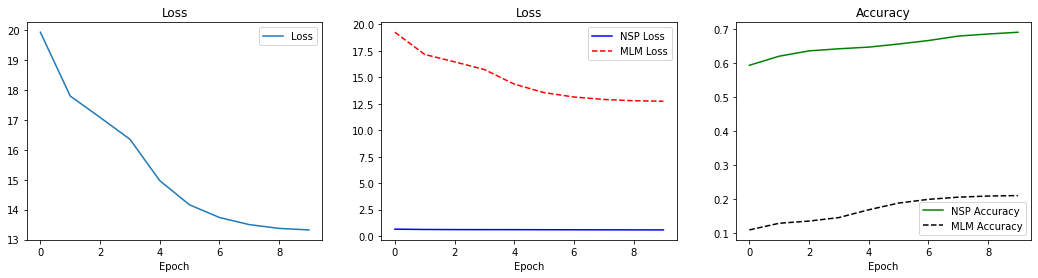

In [ ]:
first_model_history = {'Loss': history.history['loss'], 
                       'NSP Loss': history.history['nsp_loss'],
                       'MLM Loss': history.history['mlm_loss'],
                       'NSP Accuracy': history.history['nsp_acc'],
                       'MLM Accuracy': history.history['mlm_lm_acc']}

first_model_history_df = pd.DataFrame(first_model_history)
first_model_history_df = first_model_history_df.round(4)
first_model_history_df['Epoch'] = first_model_history_df.reset_index().index + 1
first_model_history_df = first_model_history_df[['Epoch', 'Loss', 'NSP Loss', 'MLM Loss', 'NSP Accuracy', 'MLM Accuracy']]
first_model_history_df.to_csv("/content/drive/MyDrive/lms/bert_pretrain/first_model_history.csv", index = False)
display(first_model_history_df)
print("\n" * 4)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['nsp_loss'], 'b-', label='NSP Loss')
plt.plot(history.history['mlm_loss'], 'r--', label='MLM Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='MLM Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

학습 과정에서 MLM Loss, NSP Loss가 안정적으로 감소한다.

<br/>

#Second Model

In [ ]:
config_2 = Config({"d_model": 128,
                   "n_head": 4,
                   "d_head": 64,
                   "dropout": 0.1,
                   "d_ff": 512,
                   "layernorm_epsilon": 0.001,
                   "n_layer": 3,
                   "n_seq": 256,
                   "n_vocab": 0,
                   "i_pad": 0})

config_2.n_vocab = len(vocab)
config_2.i_pad = vocab.pad_id()
config_2

{'d_ff': 512,
 'd_head': 64,
 'd_model': 128,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007}

<br/>

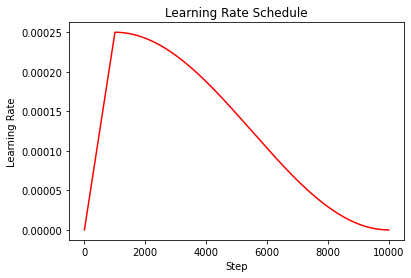






Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 128),        1850752     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                       

In [ ]:
epochs = 10
batch_size = 128

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
lrs = []
for step_num in range(train_steps):
    lrs.append(learning_rate(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.title("Learning Rate Schedule")
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.show()
print("\n" * 4)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model = build_model_pre_train(config_2)
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
                        optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})
pre_train_model.summary()

<br/><br/>

In [ ]:
# save weights callback
model_dir = '/content/drive/MyDrive/lms/bert_pretrain/model'
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/second_bert_pre_train.hdf5", monitor="mlm_lm_acc",
                                                  verbose=0, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
1000/1000 [==============================] - 120s 118ms/step - loss: 20.7646 - nsp_loss: 0.6589 - mlm_loss: 20.1056 - nsp_acc: 0.5791 - mlm_lm_acc: 0.0571
Epoch 2/10
1000/1000 [==============================] - 117s 117ms/step - loss: 18.5774 - nsp_loss: 0.6314 - mlm_loss: 17.9460 - nsp_acc: 0.6108 - mlm_lm_acc: 0.1014
Epoch 3/10
1000/1000 [==============================] - 117s 117ms/step - loss: 17.7050 - nsp_loss: 0.6196 - mlm_loss: 17.0854 - nsp_acc: 0.6303 - mlm_lm_acc: 0.1228
Epoch 4/10
1000/1000 [==============================] - 117s 117ms/step - loss: 17.2665 - nsp_loss: 0.6103 - mlm_loss: 16.6562 - nsp_acc: 0.6443 - mlm_lm_acc: 0.1301
Epoch 5/10
1000/1000 [==============================] - 117s 117ms/step - loss: 17.0053 - nsp_loss: 0.6050 - mlm_loss: 16.4003 - nsp_acc: 0.6541 - mlm_lm_acc: 0.1336
Epoch 6/10
1000/1000 [==============================] - 117s 117ms/step - loss: 16.7980 - nsp_loss: 0.6003 - mlm_loss: 16.1977 - nsp_acc: 0.6624 - mlm_lm_acc: 0.1365
Epoc

<br/><br/>

,Epoch,Loss,NSP Loss,MLM Loss,NSP Accuracy,MLM Accuracy
0,1,20.7646,0.6589,20.1056,0.5791,0.0571
1,2,18.5774,0.6314,17.9460,0.6108,0.1014
2,3,17.7050,0.6196,17.0854,0.6303,0.1228
3,4,17.2665,0.6103,16.6562,0.6443,0.1301
4,5,17.0053,0.6050,16.4003,0.6541,0.1336
5,6,16.7980,0.6003,16.1977,0.6624,0.1365
6,7,16.6422,0.5973,16.0449,0.6677,0.1386
7,8,16.5403,0.5938,15.9466,0.6757,0.1398
8,9,16.4836,0.5917,15.8919,0.6790,0.1407
9,10,16.4588,0.5896,15.8692,0.6819,0.1411


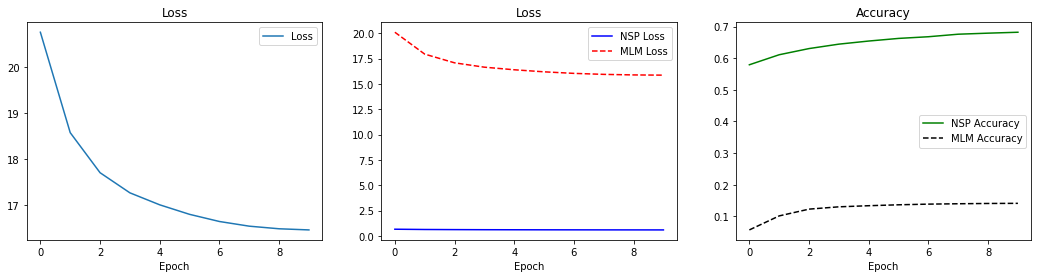

In [ ]:
second_model_history = {'Loss': history.history['loss'],
                        'NSP Loss': history.history['nsp_loss'],
                        'MLM Loss': history.history['mlm_loss'],
                        'NSP Accuracy': history.history['nsp_acc'],
                        'MLM Accuracy': history.history['mlm_lm_acc']}

second_model_history_df = pd.DataFrame(second_model_history)
second_model_history_df = second_model_history_df.round(4)
second_model_history_df['Epoch'] = second_model_history_df.reset_index().index + 1
second_model_history_df = second_model_history_df[['Epoch', 'Loss', 'NSP Loss', 'MLM Loss', 'NSP Accuracy', 'MLM Accuracy']]
second_model_history_df.to_csv("/content/drive/MyDrive/lms/bert_pretrain/second_model_history.csv", index = False)
display(second_model_history_df)
print("\n" * 4)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['nsp_loss'], 'b-', label='NSP Loss')
plt.plot(history.history['mlm_loss'], 'r--', label='MLM Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='MLM Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

학습 과정에서 MLM Loss, NSP Loss가 안정적으로 감소한다.

<br/>

#Third Model

In [ ]:
config_3 = Config({"d_model": 64,
                   "n_head": 4,
                   "d_head": 64,
                   "dropout": 0.1,
                   "d_ff": 256,
                   "layernorm_epsilon": 0.001,
                   "n_layer": 3,
                   "n_seq": 256,
                   "n_vocab": 0,
                   "i_pad": 0})

config_3.n_vocab = len(vocab)
config_3.i_pad = vocab.pad_id()
config_3

{'d_ff': 256,
 'd_head': 64,
 'd_model': 64,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007}

<br/>

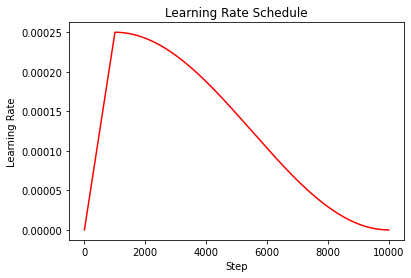






Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 64),         828224      ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                       

In [ ]:
epochs = 10
batch_size = 128

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
lrs = []
for step_num in range(train_steps):
    lrs.append(learning_rate(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.title("Learning Rate Schedule")
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.show()
print("\n" * 4)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model = build_model_pre_train(config_3)
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
                        optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})
pre_train_model.summary()

<br/><br/>

In [ ]:
# save weights callback
model_dir = '/content/drive/MyDrive/lms/bert_pretrain/model'
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/third_bert_pre_train.hdf5", monitor="mlm_lm_acc",
                                                  verbose=0, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
1000/1000 [==============================] - 94s 91ms/step - loss: 21.4481 - nsp_loss: 0.6774 - mlm_loss: 20.7707 - nsp_acc: 0.5437 - mlm_lm_acc: 0.0370
Epoch 2/10
1000/1000 [==============================] - 91s 91ms/step - loss: 19.3892 - nsp_loss: 0.6363 - mlm_loss: 18.7529 - nsp_acc: 0.6117 - mlm_lm_acc: 0.0488
Epoch 3/10
1000/1000 [==============================] - 91s 91ms/step - loss: 18.6509 - nsp_loss: 0.6261 - mlm_loss: 18.0248 - nsp_acc: 0.6294 - mlm_lm_acc: 0.0882
Epoch 4/10
1000/1000 [==============================] - 91s 91ms/step - loss: 18.1235 - nsp_loss: 0.6196 - mlm_loss: 17.5038 - nsp_acc: 0.6397 - mlm_lm_acc: 0.1046
Epoch 5/10
1000/1000 [==============================] - 91s 91ms/step - loss: 17.8164 - nsp_loss: 0.6150 - mlm_loss: 17.2014 - nsp_acc: 0.6477 - mlm_lm_acc: 0.1132
Epoch 6/10
1000/1000 [==============================] - 91s 91ms/step - loss: 17.6165 - nsp_loss: 0.6107 - mlm_loss: 17.0058 - nsp_acc: 0.6549 - mlm_lm_acc: 0.1183
Epoch 7/10
1000/

<br/><br/>

,Epoch,Loss,NSP Loss,MLM Loss,NSP Accuracy,MLM Accuracy
0,1,21.4481,0.6774,20.7707,0.5437,0.0370
1,2,19.3892,0.6363,18.7529,0.6117,0.0488
2,3,18.6509,0.6261,18.0248,0.6294,0.0882
3,4,18.1235,0.6196,17.5038,0.6397,0.1046
4,5,17.8164,0.6150,17.2014,0.6477,0.1132
5,6,17.6165,0.6107,17.0058,0.6549,0.1183
6,7,17.4909,0.6058,16.8851,0.6631,0.1213
7,8,17.4165,0.6022,16.8142,0.6687,0.1229
8,9,17.3765,0.5994,16.7772,0.6736,0.1236
9,10,17.3629,0.5987,16.7642,0.6741,0.1239


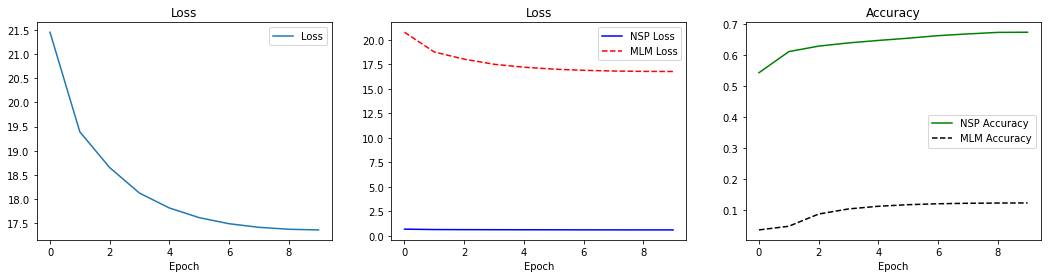

In [ ]:
third_model_history = {'Loss': history.history['loss'],
                       'NSP Loss': history.history['nsp_loss'],
                       'MLM Loss': history.history['mlm_loss'],
                       'NSP Accuracy': history.history['nsp_acc'],
                       'MLM Accuracy': history.history['mlm_lm_acc']}
                       
third_model_history_df = pd.DataFrame(third_model_history)
third_model_history_df = third_model_history_df.round(4)
third_model_history_df['Epoch'] = third_model_history_df.reset_index().index + 1
third_model_history_df = third_model_history_df[['Epoch', 'Loss', 'NSP Loss', 'MLM Loss', 'NSP Accuracy', 'MLM Accuracy']]
third_model_history_df.to_csv("/content/drive/MyDrive/lms/bert_pretrain/third_model_history.csv", index = False)
display(third_model_history_df)
print("\n" * 4)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['nsp_loss'], 'b-', label='NSP Loss')
plt.plot(history.history['mlm_loss'], 'r--', label='MLM Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='MLM Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

<br/>

#Model Selection

In [ ]:
first_df = pd.read_csv("/content/drive/MyDrive/lms/bert_pretrain/first_model_history.csv")
second_df = pd.read_csv("/content/drive/MyDrive/lms/bert_pretrain/second_model_history.csv")
third_df = pd.read_csv("/content/drive/MyDrive/lms/bert_pretrain/third_model_history.csv")

hyperparameter_tuning_result = pd.DataFrame({'Total Parameter':[4551936, 1867520, 832512],
                                             'Epoch':[10, 10, 10],
                                             'NSP Accuracy':[first_df.iloc[-1]['NSP Accuracy'], second_df.iloc[-1]['NSP Accuracy'], third_df.iloc[-1]['NSP Accuracy']],
                                             'MLM Accuracy':[first_df.iloc[-1]['MLM Accuracy'], second_df.iloc[-1]['MLM Accuracy'], third_df.iloc[-1]['MLM Accuracy']]},
                                            index=['Model 1', 'Model 2', 'Model 3'])

hyperparameter_tuning_result

,Total Parameter,Epoch,NSP Accuracy,MLM Accuracy
Model 1,4551936,10,0.6897,0.2095
Model 2,1867520,10,0.6819,0.1411
Model 3,832512,10,0.6741,0.1239


<br/>

#최종 모델

,Final Model
Model Dimension,64
Feedforwad Hidden Layer,4
Feedforwad Hidden Layer Dimension,64
Feedforward Network Dimension,256
Layer Normalization Epsilon,0.001
Number of Layer,3
Sequence Size,256
Number of Vocab,8007
Pad ID,0
Tokenizer,SentencePiece


,Epoch,Loss,NSP Loss,MLM Loss,NSP Accuracy,MLM Accuracy
0,1,21.4481,0.6774,20.7707,0.5437,0.0370
1,2,19.3892,0.6363,18.7529,0.6117,0.0488
2,3,18.6509,0.6261,18.0248,0.6294,0.0882
3,4,18.1235,0.6196,17.5038,0.6397,0.1046
4,5,17.8164,0.6150,17.2014,0.6477,0.1132
5,6,17.6165,0.6107,17.0058,0.6549,0.1183
6,7,17.4909,0.6058,16.8851,0.6631,0.1213
7,8,17.4165,0.6022,16.8142,0.6687,0.1229
8,9,17.3765,0.5994,16.7772,0.6736,0.1236
9,10,17.3629,0.5987,16.7642,0.6741,0.1239


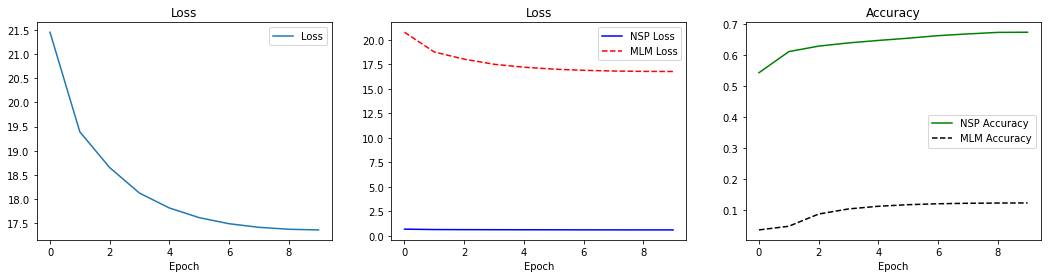

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

reorderlist = ['Model Dimension', 'Feedforwad Hidden Layer', 'Feedforwad Hidden Layer Dimension', 'Feedforward Network Dimension',
               'Layer Normalization Epsilon', 'Number of Layer', 'Sequence Size', 'Number of Vocab', "Pad ID", 'Tokenizer', 'Vocab Size', 
               'Dropout Rate', 'Learning Rate', 'Optimizer', 'Activation Function', 'Loss Function', 'Epoch', 'Batch Size', 'Total Parameter']

final_hyperparameter = pd.DataFrame({'Final Model':{'Model Dimension':64, 'Feedforwad Hidden Layer':4,
                                                    'Feedforwad Hidden Layer Dimension':64, 'Feedforward Network Dimension':256,
                                                    'Layer Normalization Epsilon':0.001, 'Number of Layer':3, 'Sequence Size':256,
                                                    'Number of Vocab':8007, "Pad ID":0,  'Tokenizer':'SentencePiece', 'Vocab Size':8000,
                                                    'Dropout Rate':0.1, 'Learning Rate':'Scheduler', 'Optimizer':'Adam',
                                                    'Activation Function':'Gelu', 'Loss Function':'Sparse Categorical Crossentropy',
                                                    'Epoch':10, 'Batch Size':128, 'Total Parameter':832512}})

final_hyperparameter = final_hyperparameter.iloc[pd.Categorical(final_hyperparameter.index,reorderlist).argsort()]

final_model_loss_df = pd.read_csv("/content/drive/MyDrive/lms/bert_pretrain/third_model_history.csv")
final_model_loss_df.to_csv("/content/drive/MyDrive/lms/bert_pretrain/final_model_history.csv", index = False)

with pd.option_context('display.max_rows',None):
  display(final_hyperparameter)
print("\n" * 4)
display(final_model_loss_df)
print("\n" * 4)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(final_model_loss_df['Loss'], label='Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(final_model_loss_df['NSP Loss'], 'b-', label='NSP Loss')
plt.plot(final_model_loss_df['MLM Loss'], 'r--', label='MLM Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(final_model_loss_df['NSP Accuracy'], 'g-', label='NSP Accuracy')
plt.plot(final_model_loss_df['MLM Accuracy'], 'k--', label='MLM Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

<br/>

#Load Model

In [53]:
model_path = "/content/drive/MyDrive/lms/bert_pretrain/model/third_bert_pre_train.hdf5"
hf = h5py.File(model_path, 'r')
print(", ".join(list(hf.keys())))

bert, enc_tokens, mlm, nsp, pooled_nsp, segments, top_level_model_weights


In [7]:
def traverse_datasets(hdf_file):

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    for path, _ in h5py_dataset_iterator(hdf_file):
        yield path

In [83]:
hasNumber = lambda stringVal: any(elem.isdigit() for elem in stringVal)

In [92]:
hdf5_data_df = pd.DataFrame({'Shape':[0], 'Data Type':[0]})
dic3 = {}
i = -1

with h5py.File(model_path, 'r') as f:
    for dset in traverse_datasets(f):
        i += 1
        dic3[i] = dset.split('/')
        hdf5_path_df = pd.DataFrame.from_dict(dic3, orient='index')
        hdf5_data_df.loc[i] = [str(f[dset].shape), str(f[dset].dtype)]

hdf5_info_df =  pd.concat([hdf5_path_df, hdf5_data_df], axis = 1)
hdf5_info_df = hdf5_info_df.reset_index().iloc[: , 2:]
hdf5_info_df = hdf5_info_df.replace(np.nan, '', regex=True)

contains_1 = list(hdf5_info_df[hdf5_info_df[4].str.contains(':')].index)
contains_2 = list(hdf5_info_df[hdf5_info_df[5].str.contains(':')].index)
contains_3 = list(hdf5_info_df[hdf5_info_df[4].str.contains('-')].index)

for i in contains_1:
  hdf5_info_df[6][i] = hdf5_info_df[4][i]
  hdf5_info_df[4][i] = ''
  if hasNumber(hdf5_info_df[3][i]) == True:
    hdf5_info_df[5][i] = hdf5_info_df[3][i]
    hdf5_info_df[3][i] = ''
  
for i in contains_2:
  hdf5_info_df[6][i] = hdf5_info_df[5][i]
  hdf5_info_df[5][i] = ''
  if hasNumber(hdf5_info_df[4][i]) == True:
    hdf5_info_df[5][i] = hdf5_info_df[4][i]
    hdf5_info_df[4][i] = ''

hdf5_info_df

,1,2,3,4,5,6,Shape,Data Type
0,bert,bert,,,embedding_7,embeddings:0,"(2, 64)",float32
1,bert,bert,encoder_layer_0,feed_forward,dense_61,bias:0,"(256,)",float32
2,bert,bert,encoder_layer_0,feed_forward,dense_61,kernel:0,"(64, 256)",float32
3,bert,bert,encoder_layer_0,feed_forward,dense_62,bias:0,"(64,)",float32
4,bert,bert,encoder_layer_0,feed_forward,dense_62,kernel:0,"(256, 64)",float32
5,bert,bert,encoder_layer_0,,layer_normalization_22,beta:0,"(64,)",float32
6,bert,bert,encoder_layer_0,,layer_normalization_22,gamma:0,"(64,)",float32
7,bert,bert,encoder_layer_0,,layer_normalization_23,beta:0,"(64,)",float32
8,bert,bert,encoder_layer_0,,layer_normalization_23,gamma:0,"(64,)",float32
9,bert,bert,encoder_layer_0,multi_head_attention,dense_57,bias:0,"(256,)",float32


In [ ]:
config_3 = Config({"d_model": 64,
                   "n_head": 4,
                   "d_head": 64,
                   "dropout": 0.1,
                   "d_ff": 256,
                   "layernorm_epsilon": 0.001,
                   "n_layer": 3,
                   "n_seq": 256,
                   "n_vocab": 0,
                   "i_pad": 0})

config_3.n_vocab = len(vocab)
config_3.i_pad = vocab.pad_id()

epochs = 10
batch_size = 128

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
lrs = []
for step_num in range(train_steps):
    lrs.append(learning_rate(float(step_num)).numpy())

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model = build_model_pre_train(config_3)
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
                        optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

In [64]:
model_path = "/content/drive/MyDrive/lms/bert_pretrain/model/third_bert_pre_train.hdf5"
pre_train_model.load_weights(model_path)
loss, nsp_loss, mlm_loss, nsp_acc, mlm_lm_acc = pre_train_model.evaluate(pre_train_inputs, pre_train_labels, verbose=1)
print("\n")
print("Loss: ", round(loss, 4))
print("NSP Loss: ",  round(nsp_loss, 4))
print("MLM Loss: ",  round(mlm_loss, 4))
print("NSP Accuracy: ",  round(nsp_acc, 4))
print("MLM Accuracy: ",  round(mlm_lm_acc, 4))

4000/4000 [==============================] - 120s 30ms/step - loss: 17.2418 - nsp_loss: 0.5926 - mlm_loss: 16.6492 - nsp_acc: 0.6857 - mlm_lm_acc: 0.1301


Loss:  17.2418
NSP Loss:  0.5926
MLM Loss:  16.6492
NSP Accuracy:  0.6857
MLM Accuracy:  0.1301


<br/><br/>



```
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/third_bert_pre_train.hdf5", monitor="mlm_lm_acc",
                                                  verbose=0, save_best_only=True, mode="max", save_freq="epoch",
                                                  save_weights_only=True)
```





```
pre_train_model.load_weights(model_path)
```



<br/>



```
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/third_bert_pre_train.hdf5", monitor="mlm_lm_acc",
                                                  verbose=0, save_best_only=True, mode="max", save_freq="epoch",
                                                  save_weights_only=False)
```





```
pre_train_model = tf.keras.models.load_model(model_path)
pre_train_model.summary()
```



<br/><br/>

save_weights_only=True인 경우에는 load_weights를 사용한다.
<br/>Pretrained Weight만 불러오기 때문에 Config를 기반으로 한 Model Compile 과정이 사전에 필요하다.
<br/>save_weights_only=False인 경우에는 tf.keras.models.load_model를 사용한다.
<br/>학습에 필요한 Pretrained Model과 Weight을 동시에 불러온다.

<br/><br/>br/>

#결론

**Pretrained Model의 잠재력**

Train Model의 기본 바탕이 되는 Pretrain Model은 어떤 Task에 적합한가?
<br/>Pretrain Model의 쓰임새는 Train Model이라는 실전에 투입되기 전까지는 알 수 없다.
<br/>Pretrain Model의 잠재력을 발굴하는 것은 실전에서 딥러닝 기계를 작동시키는 언어모델 개발자의 역량이다.
<br/>학교에서 학생의 잠재력을 발견하여 사회에서 자신의 능력을 쓸 줄 아는 성인으로 성장할 수 있게 도와주는 것처럼
<br/>딥러닝 모델 개발자는 Pretrain Model의 사용 영역을 탐색하고 유용성을 높인다.

**파라미터 사이즈**

BERT는 3억 4천만, GPT-1는 1억 1,700만, GPT-2는 15억, GPT-3는 1,750억 개의 파라미터를 가진다.
<br/>GPT–3은 시스템의 거대한 작동 규모와 뛰어난 성능으로 다른 AI 시스템과 달리 AGI에 한층 가까워졌다.

AI 기술을 기반으로 움직이는 기업은 거대 AI 모델을 개발하고 사용한다.
<br/>네이버의 HyperCLOVA는 2,040억, 딥마인드의 Gopher는 2,800억, 메가트론-튜링 NL은 5,300억, 구글의 Switch-Transformer는 1조 6,000억 개의 파라미터를 가진다.
<br/>이렇게 대기업이 모델 크기를 갖고 경쟁하는 상황에서 기업 조직이 아닌 개인이 AI 기술에 기여할 수 있는 일은 무엇인가?
<br/>대기업의 투자가 판을 이끄는 구조적인 결과인가? 개인이 기술의 발전에 기여하는 개별적인 결과인가?
<br/>과학 기술 AI라는 프로메테우스의 불을 지니고 있는 주체는 누구인가.
<br/>그 주체가 모여 AI를 기반으로 한 사회를 구성하고 있다.
<br/>개인, 기업, 가정, 학교, 지역, 국가 간의 원활한 정보 교류가 이뤄질 수 있는 AI 기술 생태계가 형성되어야 한다.


<br/>

#참고문헌

**LMS**
<br/>[cchyun](https://github.com/paul-hyun)
<br/>[mjmingd](https://github.com/mjmingd)

<br/>**논문**
<br/>[Dan Hendrycks, Kevin Gimpel, 「GAUSSIAN ERROR LINEAR UNITS (GELUS)」, arXiv:1606.08415, 2016](https://arxiv.org/abs/1606.08415)
<br/>[Devlin, J., Chang, M.-W., Lee, K., and Toutanova, K, 「BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding」, ArXiv e-prints: 1810.04805, 2018](https://arxiv.org/abs/1810.04805)

<br/>**공식 사이트**
<br/>Tensorflow
<br/>[모델 저장과 복원](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko)

<br/>**기사**
<br/>[류한석, “범용 AI의 선두주자 GPT-3가 가져온 충격”, 『나라경제 2020년 10월호』, KDI경제정보센터, 2020.10](https://eiec.kdi.re.kr/publish/columnView.do?cidx=13038&ccode=&pp=20&pg=&sel_year=2020&sel_month=10)
<br/>[Will Douglas Heaven, “초거대 AI 모델들이 탄생한 2021년”, MIT Technology Review, 2021.12.27](https://www.technologyreview.kr/%EC%B4%88%EA%B1%B0%EB%8C%80-ai-%EB%AA%A8%EB%8D%B8%EB%93%A4%EC%9D%B4-%ED%83%84%EC%83%9D%ED%95%9C-2021%EB%85%84/)

<br/>**음악**
<br/>[유정석 <질풍가도 ('쾌걸 근육맨 2세' 1기 여는노래)>](https://youtu.be/No0YMy5nXeA)
<br/>[김광진 <편지>](https://www.youtube.com/watch?v=0fzaYwdVte8)

<br/>**깃허브**
<br/>cchyun
<br/>[한글 나무위키 코퍼스](https://paul-hyun.github.io/nlp-tutorial-02-02-tokenizer/)
<br/><br/>suheeeee
<br/>[GD_NLP_8_mini_bert.ipynb](https://github.com/suheeeee/my_deeplearning_project/blob/main/going_deeper/GD_NLP_8_mini_bert.ipynb)

<br/>**웹사이트**
<br/>[나무위키](https://namu.wiki/w/%EB%82%98%EB%AC%B4%EC%9C%84%ED%82%A4:%EB%8C%80%EB%AC%B8)
<br/>[Python print tuple values | Example code](https://tutorial.eyehunts.com/python/python-print-tuple-values-example-code/)
<br/>[tensorflow 콜백함수: ModelCheckpoint](https://deep-deep-deep.tistory.com/53)
<br/>[How to read HDF5 files in Python](https://stackoverflow.com/questions/28170623/how-to-read-hdf5-files-in-python)
<br/>[reading nested .h5 group into numpy array](https://stackoverflow.com/questions/51548551/reading-nested-h5-group-into-numpy-array)
<br/>[Pandas 서로 길이가 다른 list/Series 합쳐서 DataFrame 만들기 in python & R](https://signing.tistory.com/56)
<br/>[Python에서 사전에 키 추가](https://www.delftstack.com/ko/howto/python/add-key-to-dictionary-in-python/)
<br/>[Python에서 문자열에 숫자가 포함되어 있는지 확인](https://www.delftstack.com/ko/howto/python/python-check-if-string-contains-number/)

<br/>**공부**
<br/>[Week 43 - 벤치마크 데이터 셋 그리고 KLUE](https://jiho-ml.com/weekly-nlp-43/)